In [30]:
import os
import sys

import pandas as pd
import numpy as np
from datetime import date

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import tsplot

%load_ext autoreload
%autoreload 2
%matplotlib inline

p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Machine: Linux x86_64

3.5.3 |Anaconda 4.2.0 (64-bit)| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [52]:
f = open('m.csv', 'rb').read()
data = f.decode().split('\n')
del data[-1]

start = date(2014,10,5)
start_winter_holidays = date(2014,12,20)
end_winter_holidays = date(2015,1,5)
start_easter_holidays = date(2015,4,4)
end_easter_holidays = date(2015,4,12)
end = date(2015,4,30)

start_w_holidays_index = (start_winter_holidays - start).days * 24
end_w_holidays_index = (end_winter_holidays - start).days * 24
start_e_holidays_index = (start_easter_holidays - start).days * 24
end_e_holidays_index = (end_easter_holidays - start).days * 24

serie_sem1 = pd.Series(data[:start_w_holidays_index], dtype='float')
serie_whol = pd.Series(data[start_w_holidays_index:end_w_holidays_index], dtype='float')
serie_sem2_1 = pd.Series(data[end_w_holidays_index:start_e_holidays_index], dtype='float')
serie_ehol = pd.Series(data[start_e_holidays_index:end_e_holidays_index], dtype='float')
serie_sem2_2 = pd.Series(data[end_e_holidays_index:], dtype='float')

serie = serie_sem1

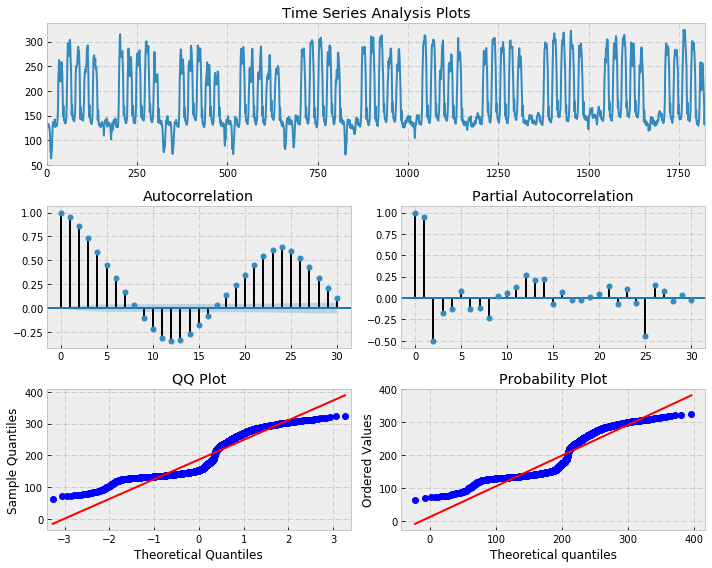

In [53]:
tsplot(serie, lags=30)

## Fitting Auto-Regressive model to the serie


In [54]:
ar = smt.AR(serie.values)

mdl = ar.fit(maxlag=30, ic='aic', trend='nc')
est_order = ar.select_order(maxlag=20, ic='aic', trend='nc')

p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))


alpha estimate: 1.24883 | best lag order = 20


The 20 lags or 20 parameters (or more, if we increase maxlag)! Any model with this many parameters is unlikely to be useful in practice.

We clearly see that there is more complexity underlying the returns process than this model can explain.

## Fitting Moving-Average model to the serie

In [57]:
mdl = smt.ARMA(serie.values, order=(0, 1)).fit(maxlag=30, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1824
Model:                     ARMA(0, 1)   Log Likelihood              -11033.803
Method:                           mle   S.D. of innovations            102.476
Date:                Mon, 17 Apr 2017   AIC                          22071.605
Time:                        15:14:34   BIC                          22082.623
Sample:                             0   HQIC                         22075.669
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.9546      0.004    219.352      0.000       0.946       0.963
                                    Roots                                    
                 Real           Imaginary           M

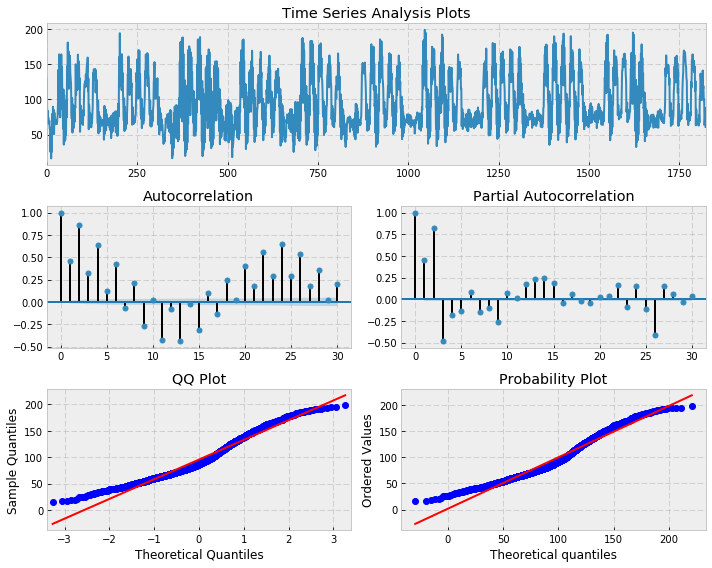

In [58]:
tsplot(mdl.resid, lags=30)

Not good

## Fitting Auto-Regressive Moving-Average model to the serie

In [59]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(2) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        p("{} {}".format(i, j))
        try:
            tmp_mdl = smt.ARMA(serie.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: pass


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

0 0
0 1
1 0
1 1
aic: 15633.44740 | order: (1, 1)


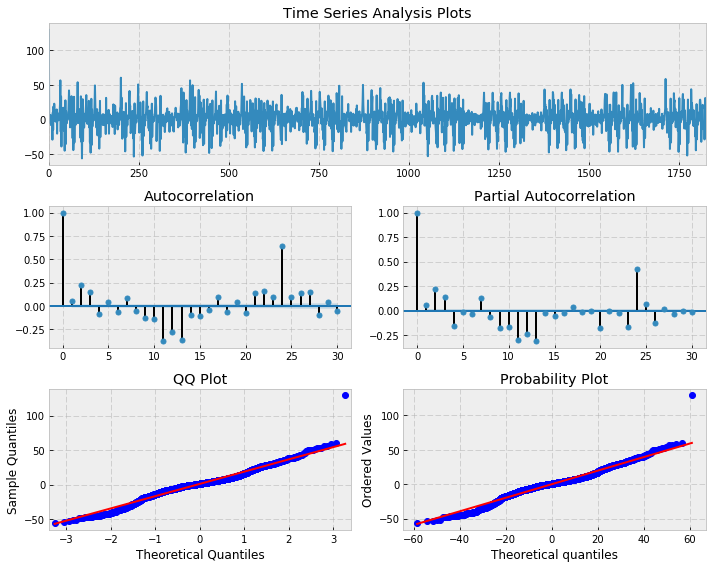

In [60]:
tsplot(best_mdl.resid, lags=30)

In [61]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(serie.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/home/timon/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/timon/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/timon/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 15190.36396 | order: (4, 1, 4)


/home/timon/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/timon/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


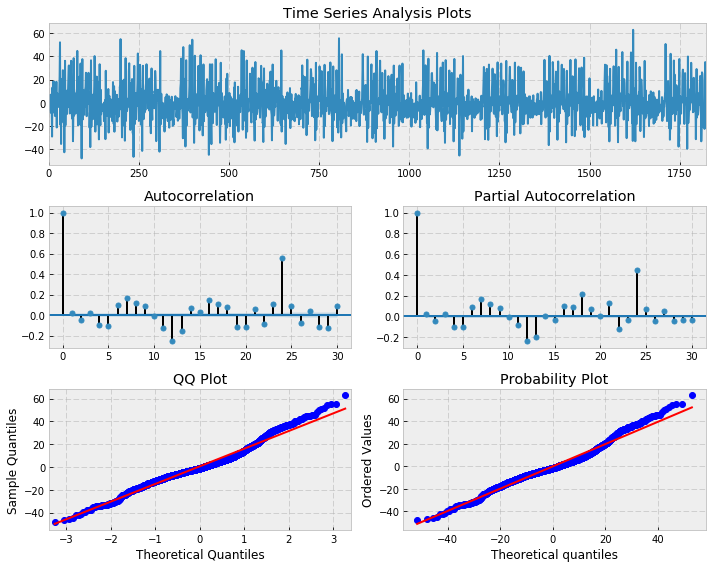

In [62]:
tsplot(best_mdl.resid, lags=30)